In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, precision_score
from libcharlotte import process_data, transform_labels, make_param_grid
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from quantstats.reports import full
from tqdm.auto import tqdm

In [2]:
# read in dataframe
df = pd.read_csv("merged_data.csv", index_col='Date', parse_dates=['Date'])
new_idx = pd.date_range(min(df.index), max(df.index), freq='D')
df = df.reindex(new_idx)

In [3]:
cols = list(df.columns)

cols.remove("crude_net")
cols.remove("products_net")
cols.remove("gas_supplied")

## Create XGBoost Model

In [4]:
param_dict = {
    'days_forecast': [15, 20, 25, 30],
    # 'move_percentile': [40, 50, 60, 70, 80, 90],
    'move_percentile': [10, 20, 30, 40, 50, 60],
    'lag_width': [5, 10, 20, 30, 40],
}

n_splits = 5

In [ ]:
param_df = make_param_grid(param_dict)
super_params = [i for _, i in param_df.iterrows()]

output = pd.DataFrame()

for i in tqdm(super_params):
    _, _, df_proc = process_data(df, cols, i.super_param_lag_width, [20*i for i in range(13)], "1990-01-01", "2021-12-31")

    crack_reindex = df.crack.reindex_like(df_proc)
    crack_targets = (crack_reindex.shift(-i.super_param_days_forecast)/crack_reindex - 1)[:-i.super_param_days_forecast]
    crack_targets = crack_targets.fillna(method = 'ffill')

    X = df_proc[:-i.super_param_days_forecast]
    _, y = transform_labels(crack_targets, i.super_param_move_percentile, False)

    model = XGBRegressor(objective='binary:logistic')

    ts_cv = TimeSeriesSplit(n_splits=n_splits)

    parameters = {
        # "n_estimators": [50, 100, 250, 500], # best is 250 but it barely matters
        # 'max_depth': [2, 4, 6, 10, 20], # best is 4 but it once again doesn't really matter
        # 'alpha' : np.logspace(-3,0, num=5),  # doesn't matter a lot
        # 'lambda': np.logspace(-2, 1, num=5), # doesn't matter a lot
    }

    scorer = make_scorer(roc_auc_score)

    gs = GridSearchCV(model, param_grid=parameters, cv=ts_cv, scoring=scorer, verbose=3)
    gs.fit(X, y)

    cvr = pd.DataFrame(gs.cv_results_)
    row = pd.concat([pd.DataFrame(i).transpose().reset_index(drop=True), cvr], axis=1)

    output = pd.concat([output, row]).fillna(method='ffill')

output = output.reset_index(drop=True)

output

  0%|          | 0/120 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.517 total time=  44.4s


In [ ]:
data = output.groupby('super_param_lag_width').mean()

plt.plot(data.index, data['mean_test_score'], 'bo-')
plt.yticks(np.arange(0, 1, step = 0.1))

plt.title("ROC Score vs Lag Width")
plt.xlabel("Days Forecast")
plt.ylabel("ROC Score")
plt.savefig("../writeups/graphs/lag_width_down.png")

plt.show()

In [ ]:
output.to_csv("cv_scores_down_move.csv")

## Trading Model

### Create Model and Predictions Based Upon Best Parameters

In [4]:
model_best = XGBRegressor(objective='binary:logistic')

days_forecast = 25
_, _, df_proc = process_data(df, cols, 20, [20*i for i in range(13)], "1990-01-01", "2019-12-31")

crack_reindex = df.crack.reindex_like(df_proc)
crack_targets = (crack_reindex.shift(-days_forecast)/crack_reindex - 1)[:-days_forecast]
crack_targets = crack_targets.fillna(method = 'ffill')

X = df_proc[:-days_forecast]
_, y = transform_labels(crack_targets, 90, True)

cutoff_date = datetime(2012, 1, 1).date()

X_train = X[X.index <= cutoff_date]
X_test = X[X.index > cutoff_date]

y_train = y[y.index <= cutoff_date]
y_test = y[y.index > cutoff_date]

model_best.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='binary:logistic', predictor='auto',
             random_state=0, reg_alpha=0, ...)

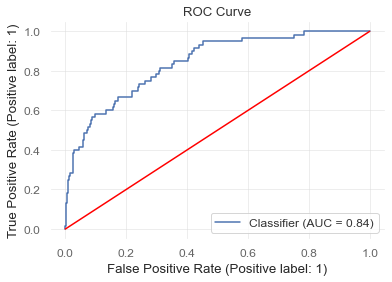

In [5]:
s = np.linspace(0, 1, 100)
y_hat = model_best.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_hat)
roc_curve_plot = RocCurveDisplay.from_predictions(y_test, y_hat)
plt.plot(s, s, color = 'red')
plt.title("ROC Curve")

# plt.savefig("../writeups/graphs/roc-80-move-down.png")
plt.show()

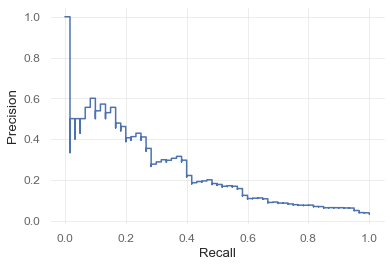

In [6]:
precision, recall, _ = precision_recall_curve(y_test, y_hat, pos_label=1)
pr_display = PrecisionRecallDisplay(precision, recall).plot()

plt.show()

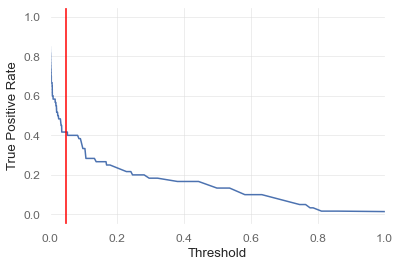

In [7]:
plt.plot(threshold, tpr)
plt.axvline(x = 0.05, color = 'red')
plt.xlim(0, 1)
plt.xlabel("Threshold")
plt.ylabel("True Positive Rate")
# plt.savefig("../writeups/graphs/threshold_down.png")
plt.show()

In [8]:
# plot precision vs threshold

results = []

for t in tqdm(np.linspace(0, 1, 101)):
    threshed = pd.Series(y_hat).apply(lambda x: int(x >= t))
    results.append([t, precision_score(y_test, threshed, zero_division=0), threshed.sum()])

results = pd.DataFrame(results, columns=['index', 'precision', 'sum'])

results.set_index('index', inplace=True)
results

  0%|          | 0/101 [00:00<?, ?it/s]

precision   sum
index                 
0.00    0.030196  1987
0.01    0.122867   293
0.02    0.170984   193
0.03    0.189542   153
0.04    0.193798   129
...          ...   ...
0.96    0.000000     0
0.97    0.000000     0
0.98    0.000000     0
0.99    0.000000     0
1.00    0.000000     0

[101 rows x 2 columns]

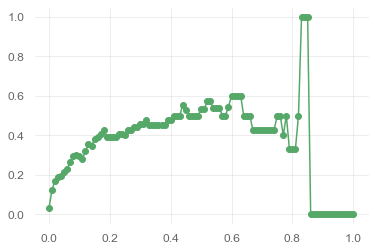

In [9]:
plt.plot(results['precision'], 'go-')
# plt.plot(results['sum'], 'bo-')
plt.show()

In [10]:
target_precision = 0.05

trade_decisions = pd.Series(y_hat, name="position")
trade_decisions.index = X_test.index
trade_decisions = trade_decisions.apply(lambda x: int(x <= target_precision))

In [11]:
crack_returns = df.crack.reindex_like(trade_decisions)
crack_returns = (crack_returns/crack_returns.shift(1) - 1).dropna()

In [19]:
trade_size_mult = 0.15

trade_decisions2 = trade_decisions.reindex_like(crack_returns)
#trade_returns = trade_decisions2*crack_returns*trade_size_mult
trade_returns = crack_returns*trade_size_mult
trade_returns.index = pd.DatetimeIndex(trade_returns.index)

In [20]:
trade_returns.count(), trade_returns.mean(), trade_returns.std(), trade_returns.std()/trade_returns.mean()

(1970, 0.0004917157186317418, 0.012356384832976509, 25.12912311886152)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-04  2012-01-04
End Period                 2019-11-22  2019-11-22
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          126.93%     184.3%
CAGR﹪                     10.95%      14.16%

Sharpe                     0.63        1.11
Prob. Sharpe Ratio         96.42%      99.89%
Smart Sharpe               0.56        0.99
Sortino                    1.01        1.57
Smart Sortino              0.9         1.4
Sortino/√2                 0.71        1.11
Smart Sortino/√2           0.64        0.99
Omega                      1.12        1.12

Max Drawdown               -20.0%      -17.16%
Longest DD Days            560         272
Volatility (ann.)          19.62%      12.74%
R^2                        0.0         0.0
Information Ratio          -0.0        -0.0
Calmar                     0.55        0

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2017-09-01  2019-01-29  2019-03-15   560    -20.004185        -17.378440
2  2012-10-01  2013-10-04  2014-04-14   560    -16.973147        -15.641666
3  2016-09-19  2017-03-01  2017-07-17   301    -14.966187        -12.609540
4  2015-08-13  2015-10-20  2016-02-18   189    -13.694113        -12.336401
5  2019-07-10  2019-09-03  2019-10-09    91    -11.756470         -6.944789

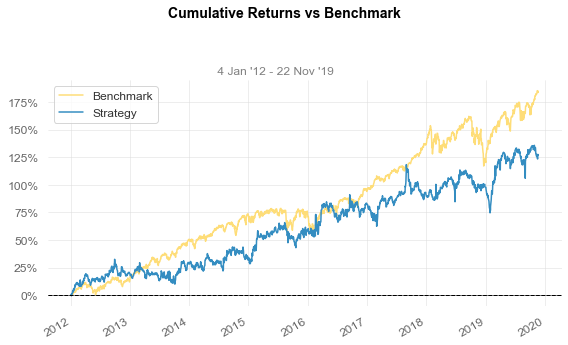

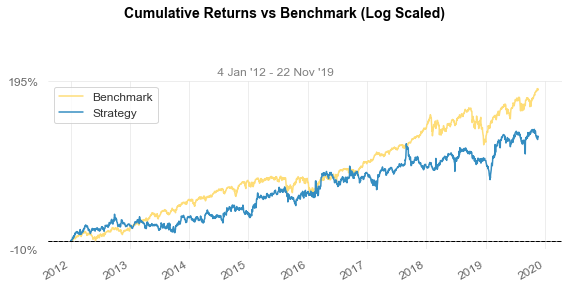

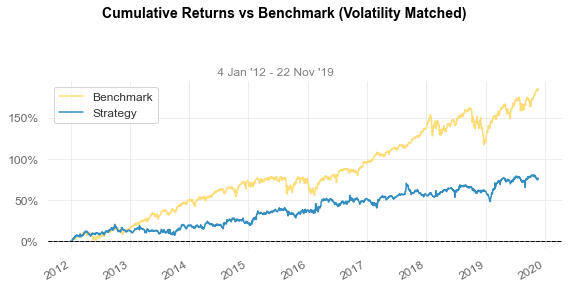

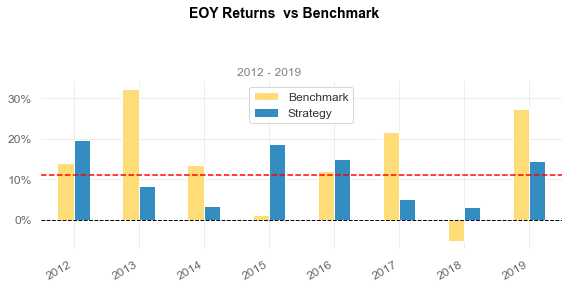

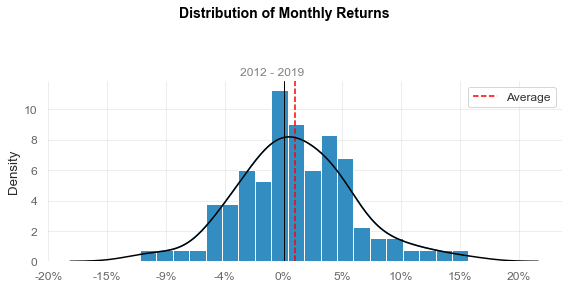

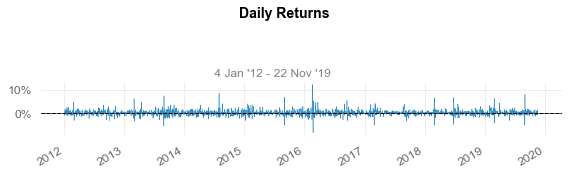

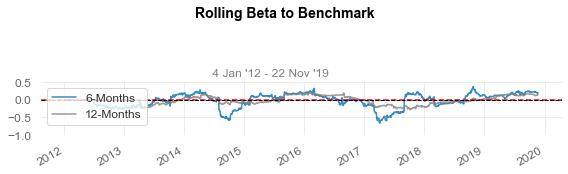

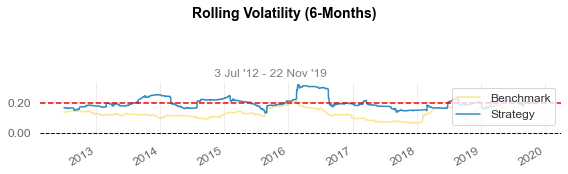

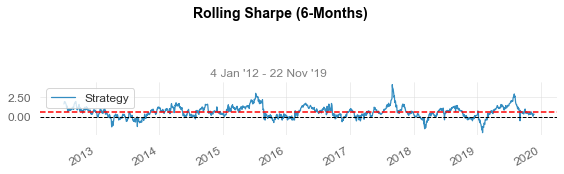

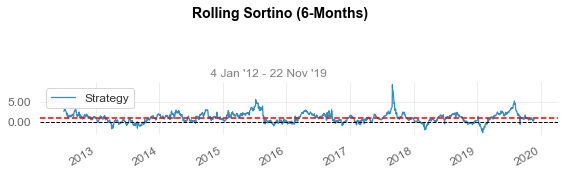

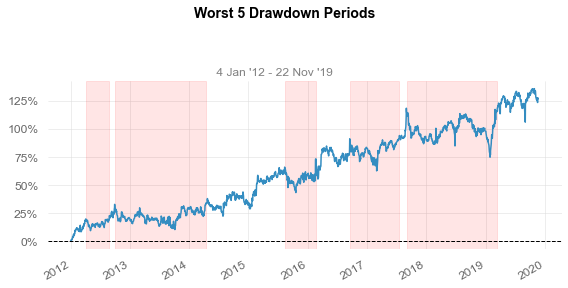

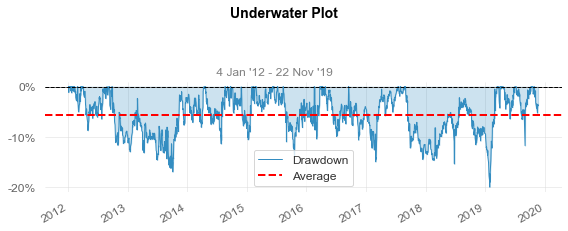

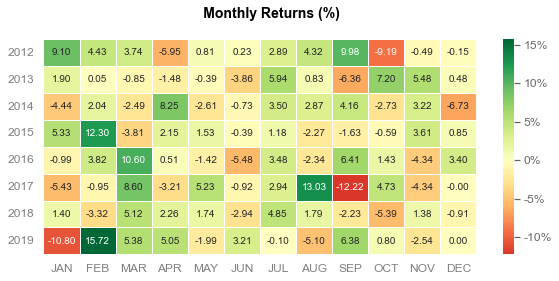

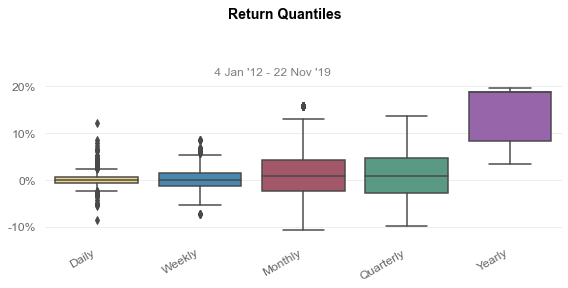

In [21]:
full(trade_returns, 'SPY')

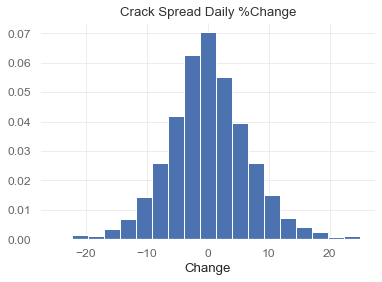

In [18]:
plt.hist(crack_returns*100, bins=np.linspace(-25, 25, 20), density=True)
plt.title("Crack Spread Daily %Change")
plt.xlabel("Change")
# plt.savefig("../Tex/graphs/crack_spread_hist.png")
plt.show()

In [ ]:
df_proc.shape